# import libraries

In [121]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from itertools import combinations
from openpyxl import Workbook
from openpyxl.styles import Font
import arabic_reshaper
from bidi.algorithm import get_display
import matplotlib.colors as mcolors
import plotly.express as px
import plotly.graph_objects as go
import time

# Read Data

In [123]:
excel_file=r"E:\Computing&Data Science\Semester 6\Tools\ASS\ass2\studentcourses.xlsx"

In [124]:
all_sheets=pd.read_excel(excel_file, sheet_name=None)

In [125]:
for sheet_name, df in all_sheets.items():
    print(f"Sheet: {sheet_name}, Rows: {len(df)}")

Sheet: علوم طبية , Rows: 1262
Sheet: صيدلة وطب اسنان, Rows: 3631
Sheet: العلوم الادارية, Rows: 7702
Sheet: الهندسة, Rows: 1374
Sheet: حاسب الي, Rows: 822


## Work in sheet_name='حاسب الي'

In [127]:
stu=pd.read_excel(excel_file, sheet_name='حاسب الي')

In [128]:
stu.head()

,Unnamed: 0,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7
0,م,رقم الطالب,اسم الطالب,التخصص,رقم المقرر,اسم المقرر,رمز المقرر,رقم الشعبة
1,1,1502302012,محمد سليمان محمد الخضيري,علوم الحاسب,150290,اختياري قسم,عال,215245
2,2,1502321001,عبدالله حمد ابراهيم الصائغ,علوم الحاسب,150286,اختياري قسم,عال,115242
3,3,1501321027,عبدالرحمن محمد ابراهيم العيسوي,هندسة الحاسب,150315,اختياري قسم,عال,115252
4,4,1501321027,عبدالرحمن محمد ابراهيم العيسوي,هندسة الحاسب,150316,اختياري قسم,عال,115253


## preprocessing 

In [130]:
stu = stu[['Unnamed: 1', 'Unnamed: 5']].rename(columns={'Unnamed: 1': 'StudentID', 'Unnamed: 5': 'CourseName'})
stu.dropna(inplace=True)

In [131]:
stu=stu.loc[1:,]

In [132]:
stu.head()

,StudentID,CourseName
1,1502302012,اختياري قسم
2,1502321001,اختياري قسم
3,1501321027,اختياري قسم
4,1501321027,اختياري قسم
5,1502322007,اختياري قسم


## Group by CourseName and collect a unique list of StudentIDs for each course


In [134]:
grouped_courses = stu.groupby('CourseName')['StudentID'].apply(lambda x: list(set(x))).reset_index()
grouped_courses['NumStudents'] = grouped_courses['StudentID'].apply(len)

In [135]:
grouped_courses.sample(5)

,CourseName,StudentID,NumStudents
30,المعادلات التفاضلية,"[1501321027, 1501301013, 1501321030]",3
75,مقدمة في هندسة الحاسب,"[1501312003, 1501312005, 1501312007, 150131201...",21
45,تقنيات الانترنت,[1502301005],1
32,النظام الإقتصادي في الإسلام,"[1502321033, 1501301014, 1501301016, 150132200...",29
62,مشروع تخرج 2,"[1501311020, 1501311021]",2


**number of student in each course**

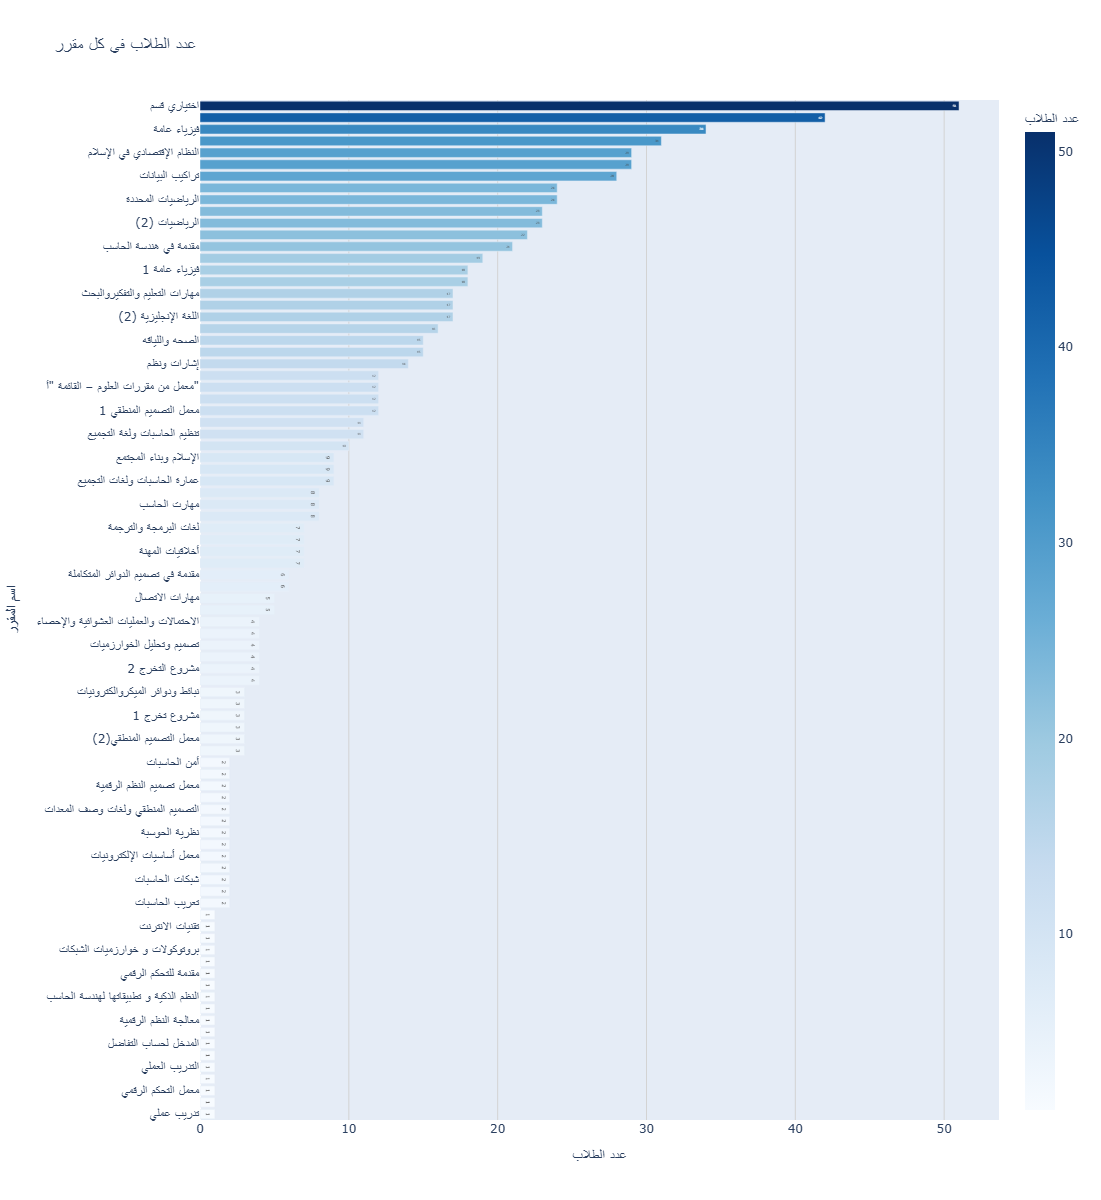

In [137]:
grouped_courses_sorted = grouped_courses.sort_values(by='NumStudents', ascending=True)

fig = px.bar(grouped_courses_sorted,
             x='NumStudents',
             y='CourseName',
             orientation='h',
             text='NumStudents',
             color='NumStudents',
             color_continuous_scale='Blues',
             labels={'NumStudents': 'عدد الطلاب', 'CourseName': 'اسم المقرر'},
             title='عدد الطلاب في كل مقرر',
             width=1000,
             height=1200)

fig.update_layout(
    xaxis_title="عدد الطلاب",
    yaxis_title="اسم المقرر",
    xaxis=dict(showgrid=True, gridwidth=1, gridcolor='lightgray'),
    yaxis=dict(showgrid=False),
    font=dict(size=12)
)

fig.show()

**Create a dictionary: {CourseName: set of StudentIDs}**

In [139]:
course_students = {
    row['CourseName']: set(row['StudentID']) for _, row in grouped_courses.iterrows()
}

## Initialize the graph 

In [141]:
G = nx.Graph()
G.add_nodes_from(course_students.keys())

for course1, course2 in combinations(course_students.keys(), 2):
    if course_students[course1] & course_students[course2]:
        G.add_edge(course1, course2)

**Apply greedy graph coloring to assign each course to a time period with no student conflicts**

In [143]:
strategies = [
    'largest_first',       
    'random_sequential',    
    'smallest_last',       
    'independent_set',      
    'connected_sequential', 
    'saturation_largest_first' 
]

results = []

for strategy in strategies:
    start_time = time.perf_counter() 
    coloring = nx.coloring.greedy_color(G, strategy=strategy)  
    end_time = time.perf_counter() 
    
    num_periods = max(coloring.values()) + 1
    
    execution_time = end_time - start_time
    
    results.append({
        'Strategy': strategy,
        'Number of Periods': num_periods,
        'Execution Time (seconds)': execution_time
    })

results_df = pd.DataFrame(results)

print("Comparison between strategies:")
print(results_df)

best_strategy = results_df.loc[results_df['Number of Periods'].idxmin()]
print("best_strategy is:")
print(best_strategy)

Comparison between strategies:
                   Strategy  Number of Periods  Execution Time (seconds)
0             largest_first                 11                  0.000957
1         random_sequential                 12                  0.000564
2             smallest_last                 10                  0.006673
3           independent_set                 15                  0.088071
4      connected_sequential                 12                  0.002766
5  saturation_largest_first                 10                  0.036217
best_strategy is:
Strategy                    smallest_last
Number of Periods                      10
Execution Time (seconds)         0.006673
Name: 2, dtype: object


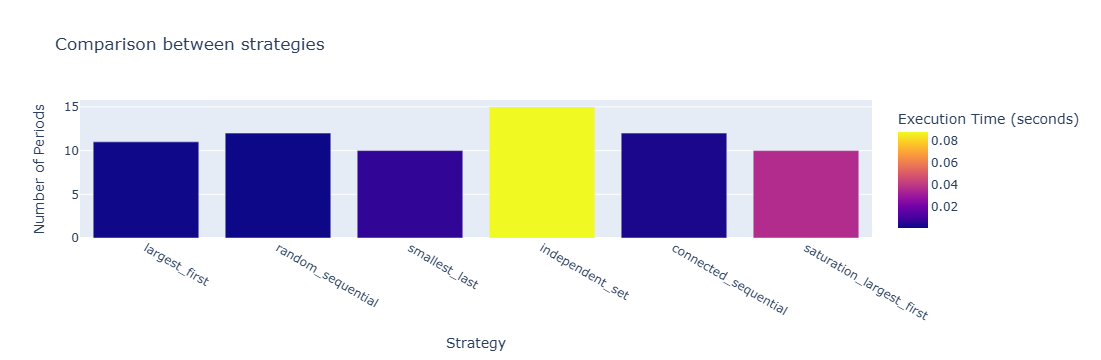

In [144]:
fig = px.bar(results_df, x='Strategy', y='Number of Periods', 
             color='Execution Time (seconds)', 
             title='Comparison between strategies',
             labels={'Number of Periods': 'Number of Periods', 'Strategy': 'Strategy'})
fig.show()

In [145]:
colors = list(mcolors.TABLEAU_COLORS.values()) + list(mcolors.CSS4_COLORS.values())
node_colors = [colors[coloring[node] % len(colors)] for node in G.nodes()]

## creates a graph of course dependencies, applies greedy coloring for time periods, and visualizes it with Plotly.


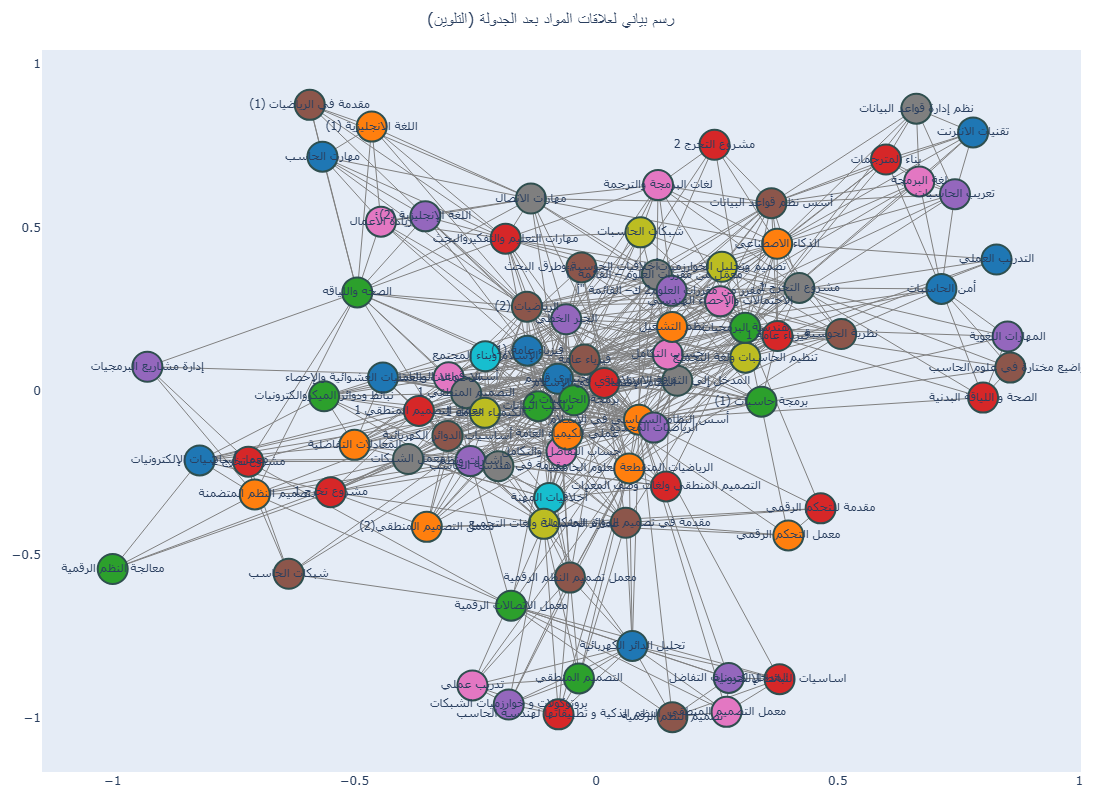

In [147]:
pos = nx.spring_layout(G, seed=42)
edge_x = []
edge_y = []
for edge in G.edges():
    x0, y0 = pos[edge[0]]
    x1, y1 = pos[edge[1]]
    edge_x.extend([x0, x1, None])
    edge_y.extend([y0, y1, None])

edge_trace = go.Scatter(
    x=edge_x, y=edge_y,
    line=dict(width=1, color='gray'),
    hoverinfo='none',
    mode='lines'
)

node_x = []
node_y = []
node_text = []
node_color = []

for node in G.nodes():
    x, y = pos[node]
    node_x.append(x)
    node_y.append(y)
    node_text.append(node)
    node_color.append(colors[coloring[node] % len(colors)])

node_trace = go.Scatter(
    x=node_x, y=node_y,
    mode='markers+text',
    text=node_text,
    textposition="middle center",
    hoverinfo='text',
    marker=dict(
        showscale=False,
        color=node_color,
        size=30,
        line=dict(width=2, color='DarkSlateGrey')
    ),
    textfont=dict(size=12, family='Tahoma')
)

fig = go.Figure(data=[edge_trace, node_trace],
                layout=go.Layout(
                    title="رسم بياني لعلاقات المواد بعد الجدولة (التلوين)",
                    title_font_size=16,
                    title_x=0.5,
                    showlegend=False,
                    hovermode='closest',
                    margin=dict(b=20, l=20, r=20, t=50),
                    xaxis=dict(showgrid=False, zeroline=False),
                    yaxis=dict(showgrid=False, zeroline=False),
                    width=1100,
                    height=800
                ))

fig.show()

**create a bar chart with Plotly to visualize course conflicts (degree) and color-codes the bars**

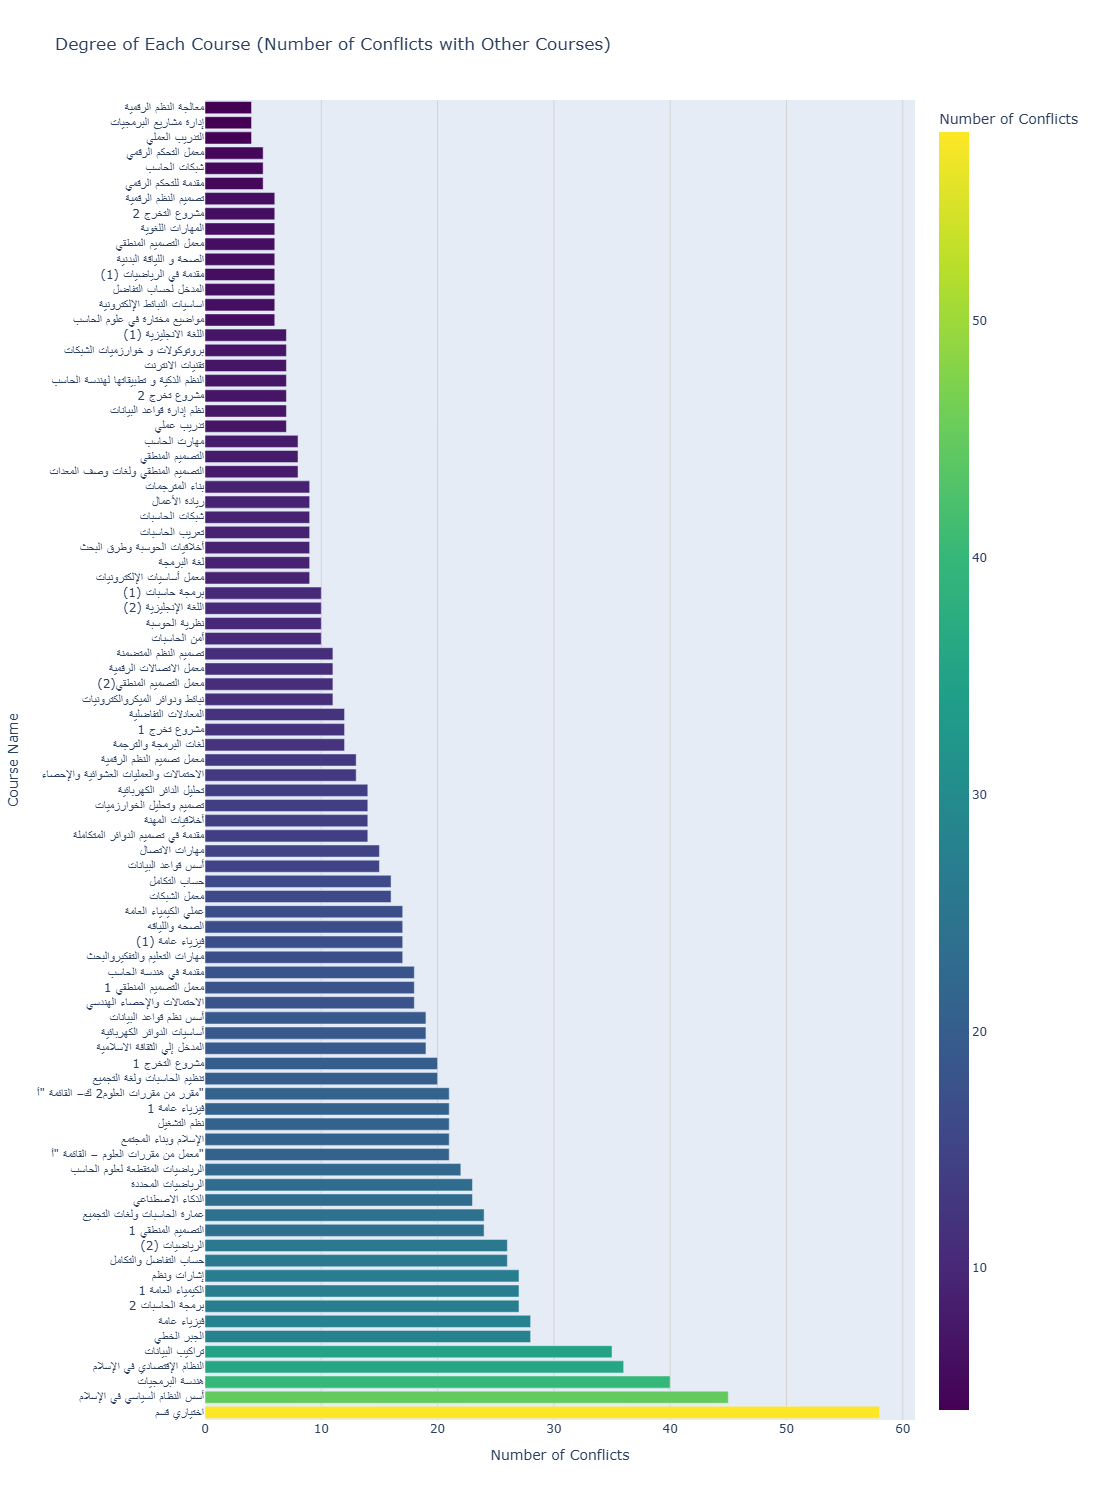

In [149]:
degree_dict = dict(G.degree())
degree_df = pd.DataFrame.from_dict(degree_dict, orient='index', columns=['Degree'])
degree_df = degree_df.reset_index().rename(columns={'index': 'CourseName'})
degree_df = degree_df.sort_values(by='Degree', ascending=False)

fig = px.bar(degree_df, 
             x='Degree', 
             y='CourseName', 
             orientation='h', 
             color='Degree', 
             color_continuous_scale='Viridis',
             labels={'Degree': 'Number of Conflicts', 'CourseName': 'Course Name'},
             title="Degree of Each Course (Number of Conflicts with Other Courses)",
             width=1200,
             height=1500
            )

fig.update_layout(
    xaxis_title="Number of Conflicts",
    yaxis_title="Course Name",
    xaxis=dict(showgrid=True, gridwidth=1, gridcolor='lightgray'),
    yaxis=dict(showgrid=False)
)

fig.show()

**Assign courses to specific days and periods based on the number of students and constraints (max students per day and periods per day), creating a schedule for courses.**

In [151]:
periods = {}
for course, color in coloring.items():
    if color not in periods:
        periods[color] = []
    periods[color].append(course)

periods_per_day = 3
max_students_per_day = 300

schedule = []
current_day = 1
current_period = 1
current_day_students = 0

for period in sorted(periods):
    period_courses = periods[period]
    period_students = sum(grouped_courses[grouped_courses['CourseName'].isin(period_courses)]['NumStudents'])

    if current_day_students + period_students <= max_students_per_day and current_period <= periods_per_day:
        day = f"Day {current_day}"
        period_name = f"Period {current_period}"
        current_period += 1
    else:
        current_day += 1
        day = f"Day {current_day}"
        current_period = 2
        period_name = "Period 1"
        current_day_students = 0

    for course in period_courses:
        num_students = grouped_courses[grouped_courses['CourseName'] == course]['NumStudents'].values[0]
        schedule.append({
            'Day': day,
            'Period': period_name,
            'Course': course,
            'Number of Students': num_students
        })

    current_day_students += period_students

In [178]:
schedule_df = pd.DataFrame(schedule)
pivoted = schedule_df.pivot_table(index='Day', columns='Period', values='Course', aggfunc=lambda x: '\n'.join(x))
pivoted = pivoted.fillna("—")

print(" جدول توزيع المقررات حسب الأيام والفترات:")
display(pivoted)

 جدول توزيع المقررات حسب الأيام والفترات:


Period,Period 1,Period 2,Period 3
Day,,,
Day 1,اختياري قسم\nفيزياء عامة (1)\nالاحتمالات والعم...,أسس النظام السياسي في الإسلام\nعملي الكيمياء ا...,هندسة البرمجيات\nتراكيب البيانات\nبرمجة الحاسب...
Day 2,النظام الإقتصادي في الإسلام\nمعمل التصميم المن...,الجبر الخطي\nالرياضيات المحددة\nإشارات ونظم\nم...,فيزياء عامة\nأساسيات الدوائر الكهربائية\nالريا...
Day 3,حساب التفاضل والتكامل\nحساب التكامل\nالاحتمالا...,التصميم المنطقي 1\nمقدمة في هندسة الحاسب\nالمد...,الكيمياء العامة 1\nتنظيم الحاسبات ولغة التجميع...
Day 4,الإسلام وبناء المجتمع\nأخلاقيات المهنة,—,—


In [153]:
wb = Workbook()
wb.remove(wb.active)  

days = sorted(set([entry['Day'] for entry in schedule]))  

for day in days:
    ws = wb.create_sheet(title=day)
    
    headers = ["Period", "Course", "Number of Students", "Student IDs"]
    ws.append(headers)
    
    bold_font = Font(bold=True)
    for cell in ws[1]:
        cell.font = bold_font
    
    day_schedule = [entry for entry in schedule if entry['Day'] == day]
    
    for entry in day_schedule:
        period = entry['Period']
        course = entry['Course']
        num_students = entry['Number of Students']
        student_ids = grouped_courses[grouped_courses['CourseName'] == course]['StudentID'].values[0]
        row = [period, course, num_students, ', '.join(map(str, student_ids))]
        ws.append(row)

wb.save(r"E:/Computing&Data Science/Semester 6/Tools/ASS/ass2/exam_schedule_by_day.xlsx")
print("Schedule saved to 'exam_schedule_by_day.xlsx'")

Schedule saved to 'exam_schedule_by_day.xlsx'
